# Inference

In [1]:
# External Libs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import pandas as pd
import os
import scipy
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from rainbowgram.wave_rain import wave2rain, rain2wave
from rainbowgram.rain2graph import rain2graph
import warnings
warnings.filterwarnings('ignore')

# Internal Libs
from lib import networks, util, signal_utils
from lib.normalizer import DataNormalizer
from data.nsynth_loader import NSynth, to_one_hot

Loading Configuration JSON file

In [2]:
option_name = 'progae_growgansynth_nsynth_kl01_recon1_zrecon100.json'
option_path = os.path.join('./options/', option_name)

opt = util.load_json(option_path)
opt_train = opt['train']
opt_test = opt['test']
checkpoints_path = os.path.join(opt_train['checkpoints_dir'], opt['experiment_name'])
output_dir = os.path.join(checkpoints_path, opt_test['output_dir'])
util.mkdir(output_dir)
device = 'cuda:0'
ch_size = opt['model'].get('in_ch', 2)
print('DEVICE: {}, Channel Size: {}'.format(device, ch_size))

DEVICE: cuda:0, Channel Size: 2


Loading dataset loader

In [3]:
dataset = NSynth(opt)
datapath = os.path.join(dataset.root,'audio')
df = dataset.df
df.head()

Instruments families selected: ['mallet', 'string', 'brass', 'reed', 'flute']
WARNING. Normalization parameters are hardcoded!
p_a: 0.0026
p_b: 0.0185
s_a: 0.0341
s_b: -0.3292


note  sample_rate  pitch  instrument_source instrument_family_str  \
17  85862        16000     75                  0                string   
19  35953        16000     65                  0                  reed   
20  30131        16000     67                  0                 flute   
26  55879        16000     56                  0                string   
27  60247        16000     41                  0                string   

         instrument_str                     note_str  \
17  string_acoustic_006  string_acoustic_006-075-025   
19    reed_acoustic_041    reed_acoustic_041-065-127   
20   flute_acoustic_030   flute_acoustic_030-067-100   
26  string_acoustic_075  string_acoustic_075-056-050   
27  string_acoustic_069  string_acoustic_069-041-050   

                            qualities_str instrument_source_str  velocity  \
17        [bright, nonlinear_env, reverb]              acoustic        25   
19                               [reverb]              acoustic       127   
20                                     []              acoustic       100   
26       [fast_decay, percussive, reverb]              acoustic        50   
27  [long_release, nonlinear_env, reverb]              acoustic        50   

    instrument_family  instrument                       qualities  \
17                  8          52  [1, 0, 0, 0, 0, 0, 1, 0, 1, 0]   
19                  7         427  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
20                  2         744  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
26                  8         623  [0, 0, 0, 1, 0, 0, 0, 1, 1, 0]   
27                  8         580  [0, 0, 0, 0, 1, 0, 1, 0, 1, 0]   

                           file  
17  string_acoustic_006-075-025  
19    reed_acoustic_041-065-127  
20   flute_acoustic_030-067-100  
26  string_acoustic_075-056-050  
27  string_acoustic_069-041-050

Loading network and parameters for autoencoder

In [ ]:
autoencoder = networks.instantiate_autoencoder(opt).to(device)

snap_path = os.path.join(checkpoints_path, 'snap').
autoencoder.load_state_dict(torch.load(os.path.join(snap_path, '10_AE.pth'), map_location=device))

In case the autoencoder model is splited into two different instances, encoder/decoder

In [4]:
class Autoencoder():
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def encode(self, data):
        return self.encoder(data)
    
    def decode(self, data):
        return self.decoder(data)
    
    def __call__(self, data):
        latent = self.encode(data)
        return self.decode(latent), latent
        

encoder = networks.instantiate_encoder(opt).to(device)
decoder = networks.instantiate_decoder(opt).to(device)

snap_path = os.path.join(checkpoints_path, 'snap')
encoder.load_state_dict(torch.load(os.path.join(snap_path, '10_encoder.pth'), map_location=device))
decoder.load_state_dict(torch.load(os.path.join(snap_path, '10_decoder.pth'), map_location=device))
autoencoder = Autoencoder(encoder, decoder)

In [5]:
eval_config = {'phase': len(autoencoder.encoder.enc_net)-1, 'alpha': 0, 'status':'stable'}
autoencoder.encoder.config = eval_config
autoencoder.decoder.config = eval_config

### Helper Functions

In [6]:
def generate(data, pitch=None):
    if pitch is not None:
        #decoded_feat = decoder(latent, to_one_hot(128, pitch).unsqueeze(0).to(device))
        decoded_feat, latent = autoencoder(data)
    else:
        decoded_feat, latent = autoencoder(data)
    decoded_feat = decoded_feat.squeeze().cpu().detach().numpy()
    return decoded_feat, latent

def interpolate(data_1, data_2, pitch, alpha=0.5):
    latent_1, skip_1 = autoencoder.encode(data_1)
    #latent_1 = encoder(data_norm.normalize(data_1))
    latent_2, skip_2 = autoencoder.encode(data_2)
    #latent_2 = encoder(data_norm.normalize(data_2))
    
    latent = latent_1 * alpha + (1-alpha) * latent_2
    
    #decoded_feat = autoencoder.decoder(latent, to_one_hot(128, pitch).unsqueeze(0).to(device))
    decoded_feat = autoencoder.decode(latent, skip_1)
    decoded_feat = decoded_feat.squeeze().cpu().detach().numpy()
    return reconstruct(decoded_feat[0,:,:],decoded_feat[1,:,:])

def arrange_data(sample):
    sample = sample.astype(np.float)
    if ch_size == 2:
        logmel, mel_phase = dataset.compute_features(sample)
        logmel = torch.from_numpy(logmel).float()
        logmel = logmel.unsqueeze(0)
        mel_phase = torch.from_numpy(mel_phase).float()
        mel_phase = mel_phase.unsqueeze(0)
        data = torch.cat([logmel, mel_phase], dim = 0)
    else:
        logmel = dataset.compute_features(sample)
        logmel = torch.from_numpy(logmel).float()
        logmel = logmel.unsqueeze(0)
        data = logmel

    data = dataset.data_norm.normalize(data)
    data = data.unsqueeze(0).to(device) # Batch dim
    return data

def denorm(spec=None, IF=None):
    if spec is not None:
        spec = dataset.data_norm.denormalize(spec, s_a=0.0341, s_b=-0.3292)#s_a=0.060437, s_b=0.034964)
    if IF is not None:
        IF = dataset.data_norm.denormalize_IF(IF, p_a=0.0026, p_b=0.0185)#p_a=0.0034997, p_b=-0.010897)
    return spec, IF

def reconstruct_phase(IF):
    return np.cumsum(IF * np.pi, axis=1)

def reconstruct(data):
    #spec, IF = data_norm.denormalize(spec, IF, s_a=0.060437, s_b=0.034964, p_a=0.0034997, p_b=-0.010897)
    #spec = dataset.data_norm.denormalize(spec, s_a=0.060437, s_b=0.034964)
    #IF = dataset.data_norm.denormalize_IF(IF, p_a=0.0034997, p_b=-0.010897)
    spec = data[0,:,:] if len(data.shape) == 3 else data
    IF = data[1,:,:] if ch_size == 2 else None
        
    spec, IF = denorm(spec, IF)
    spec, IF = signal_utils.melspecgrams_to_specgrams(spec, IF)
    spec = np.vstack((spec,spec[1023]))
    spec =  np.exp(spec) - 1.0e-6
    reconstruct_magnitude = np.abs(spec)
    if IF is not None:
        IF = np.vstack((IF,IF[1023]))
        reconstruct_phase_angle = reconstruct_phase(IF)
        stft = polar2rect(reconstruct_magnitude, reconstruct_phase_angle)
        audio = librosa.istft(stft, hop_length = 512, win_length=2048, window = 'hann')
    else:
        audio = librosa.griffinlim(reconstruct_magnitude, )
    return audio

def polar2rect(mag, phase_angle):
    """Convert polar-form complex number to its rectangular form."""
    temp_mag = np.zeros(mag.shape,dtype=np.complex_)
    temp_phase = np.zeros(mag.shape,dtype=np.complex_)

    for i, time in enumerate(mag):
        for j, time_id in enumerate(time):
            temp_mag[i,j] = np.complex(mag[i,j])

    for i, time in enumerate(phase_angle):
        for j, time_id in enumerate(time):
            temp_phase[i,j] = np.complex(np.cos(phase_angle[i,j]), np.sin(phase_angle[i,j]))
    return temp_mag * temp_phase

def export_audio(sample, path, rate= 16000):
    sample=np.int16(sample/np.max(np.abs(sample)) * 32767)
    scipy.io.wavfile.write(path, rate, sample)

def plot_spectrogram_from_samples(sample):
    sample = sample.astype(np.float)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(sample)), ref=np.max)
    plt.figure()
    librosa.display.specshow(D, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-frequency power spectrogram')

def rainbowgram(sample, rate = 16000):
    sample = sample.astype(np.float)
    rain = wave2rain(sample, sr=rate, stride=256, log_mag=True, clip=0.1)
    rain2graph(rain)
    fig, ax = plt.subplots()
    ax.show()
    
def plot_spectrogram_spec(spec, IF, is_denorm= False, is_mel=True, y_axis = 'log'):
    if not is_denorm:
        spec, IF = denorm(spec, IF)
    if is_mel:
        spec, IF = signal_utils.melspecgrams_to_specgrams(spec, IF)
    # Removing outliers for a correct visualization
    plt.figure()
    librosa.display.specshow(spec, y_axis=y_axis)
    plt.colorbar()
    plt.title('Log-frequency Power Spectrogram')

def plot_spectrogram_IF(data, is_denorm= False, is_mel=True, y_axis = 'log'):
    spec = data[0,:,:] if len(data.shape) == 3 else data
    IF = data[1,:,:] if ch_size == 2 else None
    if IF is None:
        return
    if not is_denorm:
        spec, IF = denorm(spec, IF)
    if is_mel:
        spec, IF = signal_utils.melspecgrams_to_specgrams(spec, IF)
    # Removing outliers for a correct visualization
    IF[IF<-1.5] = -1.5
    IF[IF>1.5] = 1.5
    plt.figure()
    librosa.display.specshow(IF, y_axis=y_axis)
    plt.colorbar()
    plt.title('Log-frequency Phase Spectrogram')

def scatter_fuzzy(x, y, method='pca', export=False, title='', colormap = 'winter'): #hsv for multiple colormap
    if method == 'pca':
        pca = PCA(2)
        projection = pca.fit_transform(x)
    elif method == 't-sne':
        projection = TSNE(random_state=123).fit_transform(x)        
    fig, ax = plt.subplots(1,1, figsize=(7, 7))
    plot = ax.scatter(projection[:, 0], projection[:, 1], c=y, edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap(colormap, len(np.unique(y))))
    fig.colorbar(plot, ax=ax, orientation='vertical')

def scatter_labels(x,y, method='pca', export=False, title='', color_labels= None): #colormap = 'winter'
    if method == 'pca':
        pca = PCA(2)
        projection = pca.fit_transform(x)
    elif method == 't-sne':
        projection = TSNE(random_state=123).fit_transform(x)
    colors = plt.cm.rainbow(np.linspace(0,1,len(np.unique(y))))
    fig, ax = plt.subplots(figsize = (7,7))
    for idx, color_id in enumerate(np.unique(y)):
        ix = np.where(y == color_id)
        if color_labels is not None:
            ax.scatter(projection[ix][:,0], projection[ix][:,1], 
                        c = colors[idx], label = color_labels[color_id], s=3)
        else:
            ax.scatter(projection[ix][:,0], projection[ix][:,1], 
                        c = colors[idx], label = color_id)            
    ax.legend(markerscale=4.,scatterpoints=1)
    plt.show()

# EDA

Autoencoder latent representation.

In [12]:
emb_list = []
pitch_label = []
instr_label = []
total_iter = 2000
for idx, data in enumerate(dataset):
    data['anc_data'] = data['anc_data'].unsqueeze(0).to(device)
    #data['trg_data'] = data['trg_data'].unsqueeze(0).to(device)
    
    #latent, _ = autoencoder.encode(data['src_data'])
    latent = autoencoder.encode(data['anc_data'])[0]
    
    
    emb_list.append(latent.squeeze().cpu().detach().numpy())
    pitch_label.append(torch.argmax(data['anc_pitch'], dim=0, keepdims=False).numpy())
    instr_label.append(data['anc_instr'].numpy())
    if idx % 100 == 0:
        print('{} samples...'.format(idx))
    if idx >= total_iter-1:
        print('{} samples have been Encoded/Decoded'.format(idx))
        break
x = np.stack(emb_list,axis=0)
y_pitch = np.array(pitch_label)
y_instr = np.array(instr_label)

0 samples...
100 samples...
200 samples...
300 samples...
400 samples...
500 samples...
600 samples...
700 samples...
800 samples...
900 samples...
1000 samples...
1100 samples...
1200 samples...
1300 samples...
1400 samples...
1500 samples...
1600 samples...
1700 samples...
1800 samples...
1900 samples...
1999 samples have been Encoded/Decoded


In [26]:
color_labels = {1 :'brass', 2:'flute', 5 : 'mallet', 7 :'reed', 8 : 'string'}

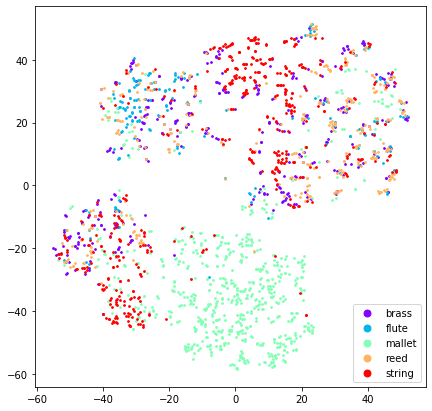

In [14]:
scatter_labels(x, y_instr, 't-sne', color_labels = color_labels)

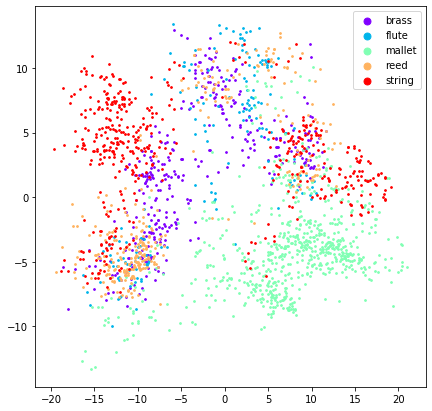

In [15]:
scatter_labels(x, y_instr, 'pca', color_labels = color_labels)

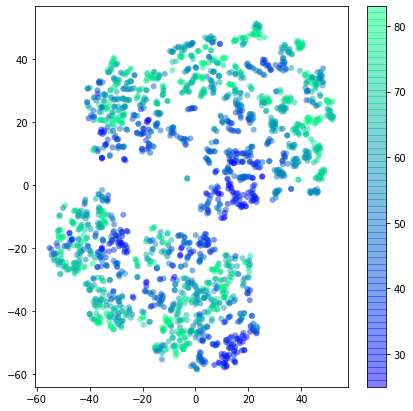

In [16]:
scatter_fuzzy(x, y_pitch, 't-sne')

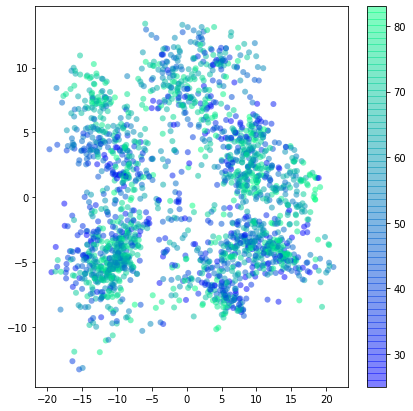

In [17]:
scatter_fuzzy(x, y_pitch, 'pca')

Latent Representation with Triplets

In [24]:
z_timbre_list = []
z_pitch_list = []
pitch_label = []
instr_label = []
total_iter = 2000
for idx, data in enumerate(dataset):
    data['anc_data'] = data['anc_data'].unsqueeze(0).to(device)
    
    # latent, skip = autoencoder.encode(data['anc_data']) #data['src_data']
    latent = autoencoder.encode(data['anc_data']) #data['src_data']
    
    z_timbre, z_pitch = torch.chunk(latent, chunks=2, dim=1)
    
    z_timbre_list.append(z_timbre.squeeze().cpu().detach().numpy())
    z_pitch_list.append(z_pitch.squeeze().cpu().detach().numpy())
    pitch_label.append(torch.argmax(data['anc_pitch'], dim=0, keepdims=False).numpy())
    instr_label.append(data['anc_instr'].numpy())
    if idx % 100 == 0:
        print('{} samples...'.format(idx))
    if idx >= total_iter-1:
        print('{} samples have been Encoded/Decoded'.format(idx))
        break
z_timbre = np.stack(z_timbre_list,axis=0)
z_pitch = np.stack(z_pitch_list,axis=0)
y_pitch = np.array(pitch_label)
y_instr = np.array(instr_label)

0 samples...
100 samples...
200 samples...
300 samples...
400 samples...
500 samples...
600 samples...
700 samples...
800 samples...
900 samples...
1000 samples...
1100 samples...
1200 samples...
1300 samples...
1400 samples...
1500 samples...
1600 samples...
1700 samples...
1800 samples...
1900 samples...
1999 samples have been Encoded/Decoded


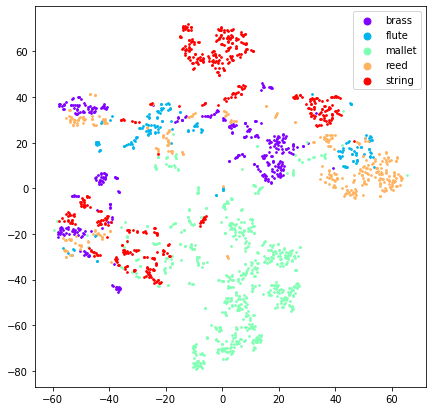

In [27]:
scatter_labels(z_timbre, y_instr, 't-sne', color_labels = color_labels)

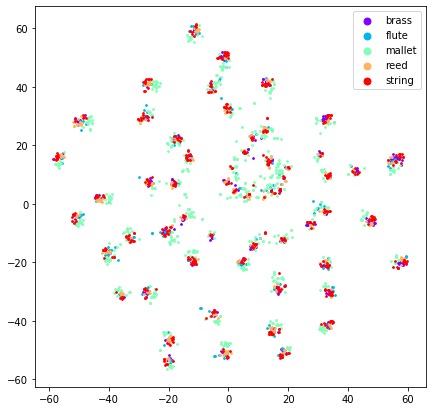

In [28]:
scatter_labels(z_pitch, y_instr, 't-sne', color_labels = color_labels)

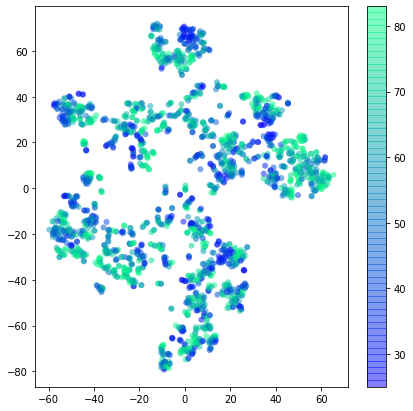

In [29]:
scatter_fuzzy(z_timbre, y_pitch, 't-sne')

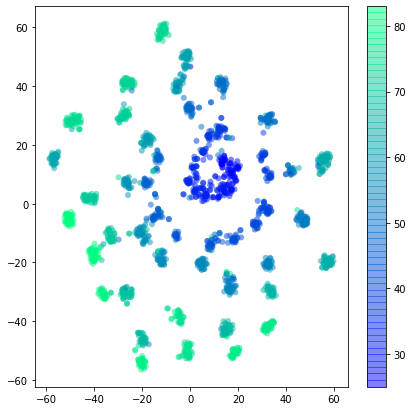

In [30]:
scatter_fuzzy(z_pitch, y_pitch, 't-sne')

## Skip Connection Visualization

## Rainbowgrams

In [ ]:
sample_name = 'string_acoustic_022-040-025'
wave, sr = librosa.core.load(os.path.join(datapath, sample_name + '.wav'), sr=16000)
rain = wave2rain(wave, sr=sr,n_fft=2048, stride=512, power= 1,log_mag=True, clip=0.1, mel_freq=True)
print(rain.shape)

ax = rain2graph(rain)

scaler = ax.set_yscale
kwargs = dict()
#kwargs['basey'] = 2
#kwargs['linthreshy'] = 1000.0
#kwargs['linscaley'] = 0.5
#scaler(mode, **kwargs)
plt.show()

## Time Analysis

In [6]:
iters = 500
timer = 0
device = 'cuda:0'
autoencoder.to(device)
for idx, data in enumerate(dataset):
    data['src_data'] = data['src_data'].unsqueeze(0).to(device)
    
    start_iter = time.time()
    autoencoder(data['src_data'])
    timer += time.time() - start_iter    
    
    if idx % 100 == 0:
        print('{} samples...'.format(idx))
    if idx >= iters-1:
        break

print('Device={} | Iters={} | Total time={} | Average Time={}'.format(
        device, iters, timer, timer/iters))

KeyError: 'src_data'

## Audio Reconstruction

In [67]:
df[(df['instrument_family_str'] == 'flute') & (df['velocity'] == 25) & (df['pitch'] == 45)].head()

note  sample_rate  pitch  instrument_source instrument_family_str  \
4227     81126        16000     45                  2                 flute   
30892   111950        16000     45                  0                 flute   
82993   113604        16000     45                  0                 flute   
116443   89968        16000     45                  2                 flute   
117889  131950        16000     45                  2                 flute   

             instrument_str                     note_str qualities_str  \
4227    flute_synthetic_004  flute_synthetic_004-045-025        [dark]   
30892    flute_acoustic_014   flute_acoustic_014-045-025            []   
82993    flute_acoustic_003   flute_acoustic_003-045-025            []   
116443  flute_synthetic_002  flute_synthetic_002-045-025  [distortion]   
117889  flute_synthetic_005  flute_synthetic_005-045-025        [dark]   

       instrument_source_str  velocity  instrument_family  instrument  \
4227               synthetic        25                  2         326   
30892               acoustic        25                  2         299   
82993               acoustic        25                  2         132   
116443             synthetic        25                  2         141   
117889             synthetic        25                  2         442   

                             qualities                         file  
4227    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  flute_synthetic_004-045-025  
30892   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   flute_acoustic_014-045-025  
82993   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   flute_acoustic_003-045-025  
116443  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]  flute_synthetic_002-045-025  
117889  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  flute_synthetic_005-045-025

In [9]:
sample_list = ['string_acoustic_022-040-025', 'reed_acoustic_041-065-127']
sample_name = sample_list[0]

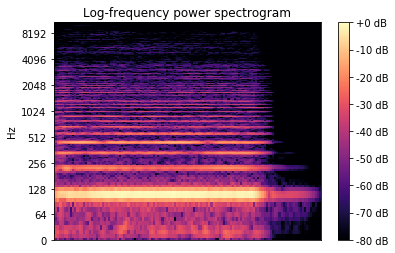

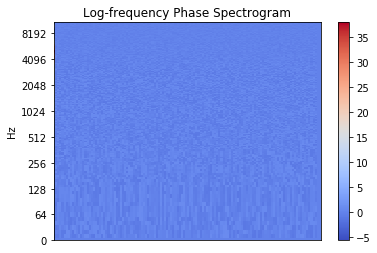

In [10]:
_, sample = scipy.io.wavfile.read(os.path.join(datapath, sample_name + '.wav'))
data = arrange_data(sample)
data_arr = data[0,:,:,:].cpu().detach().numpy()

plot_spectrogram_from_samples(sample)
plot_spectrogram_IF(data_arr)
#rainbowgram(sample)
ipd.Audio(sample, rate=16000)

In [ ]:
#ToErase
def arrange_data(sample):
    sample = sample.astype(np.float)
    if ch_size == 2:
        logmel, mel_phase = dataset.compute_features(sample)
        logmel = torch.from_numpy(logmel).float()
        logmel = logmel.unsqueeze(0)
        mel_phase = torch.from_numpy(mel_phase).float()
        mel_phase = mel_phase.unsqueeze(0)
        data = torch.cat([logmel, mel_phase], dim = 0)
    else:
        logmel = dataset.compute_features(sample)
        logmel = torch.from_numpy(logmel).float()
        logmel = logmel.unsqueeze(0)
        data = logmel

    data = dataset.data_norm.normalize(data)
    data = data.unsqueeze(0).to(device) # Batch dim
    return data

(1024, 128)
(1024, 128)


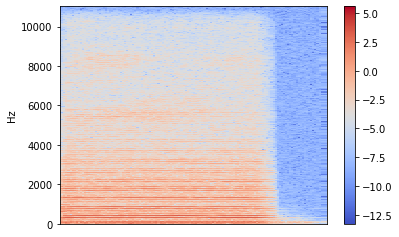

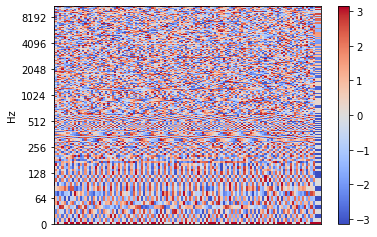

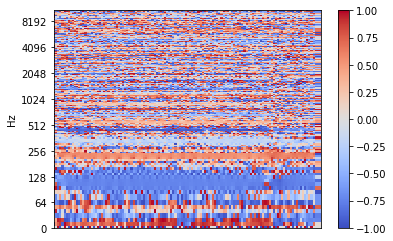

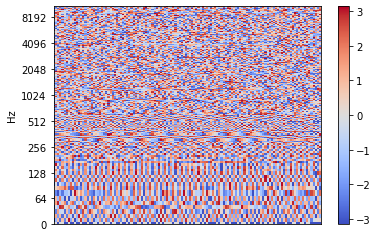

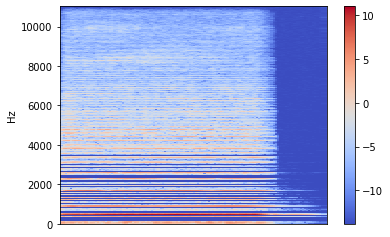

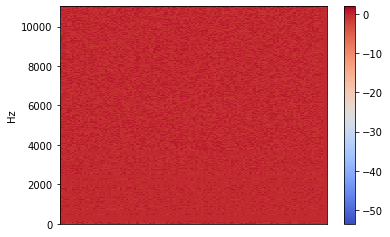

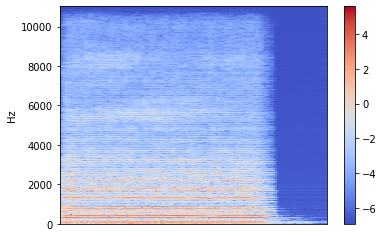

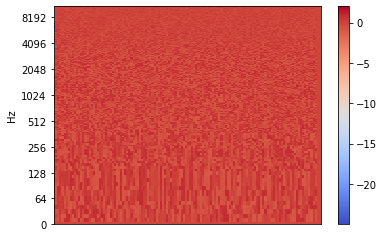

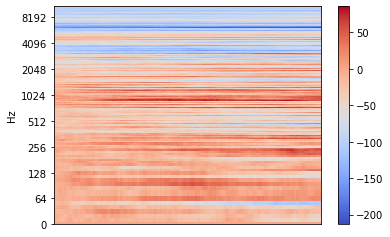

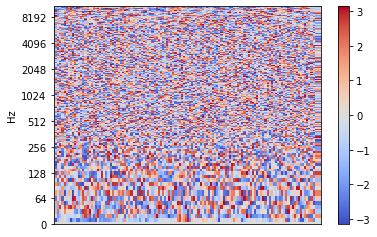

In [82]:
import librosa
import math
def expand(mat):
    while not math.log(mat.shape[1], 2).is_integer():
        expand_vec = np.expand_dims(mat[:,-1],axis=1)
        mat = np.hstack((mat,expand_vec))
    return mat
_, sample = scipy.io.wavfile.read(os.path.join(datapath, sample_name + '.wav'))
sample = sample / np.iinfo(np.int16).max
sample = sample.astype(np.float)

spec = librosa.stft(sample, n_fft=2048, hop_length = 512)

magnitude = np.log(np.abs(spec)+ 1.0e-6)[:1024]
magnitude = expand(magnitude)

# No norm log mag
_ = plt.figure()
librosa.display.specshow(magnitude, y_axis='linear')
plt.colorbar()

# Phase no norm
angle =np.angle(spec)
phase = expand(angle)
_ = plt.figure()
librosa.display.specshow(phase, y_axis='log')
plt.colorbar()

# IF 
IF = signal_utils.instantaneous_frequency(angle, time_axis=1)[:1024]
IF = expand(IF)
_ = plt.figure()
librosa.display.specshow(IF, y_axis='log')
plt.colorbar()

# recon Phase
recon_p = np.cumsum(IF * np.pi, axis = 1)
recon_p = (recon_p + np.pi) % (2 * np.pi) - np.pi
_ = plt.figure()
librosa.display.specshow(recon_p, y_axis='log')
plt.colorbar()

#mel = librosa.feature.melspectrogram(sample, sr=16000, n_fft=2048 , hop_length=512)
#mel_db = librosa.power_to_db(mel, ref=np.max)
#print(mel.shape)
#_ = plt.figure()
#librosa.display.specshow(np.log(np.abs(mel)+ 1.0e-6)[:1024], y_axis='log')
#plt.colorbar()

#mel = librosa.filters.mel(sr=16000, n_fft=2048, n_mels=1024)[:,:1024]
#logmel = mel.dot(magnitude)
#mel_p = mel.dot(IF)

logmel, mel_p = signal_utils.specgrams_to_melspecgrams(magnitude, IF)

# mel mag 
_ = plt.figure()
librosa.display.specshow(logmel, y_axis='linear')
plt.colorbar()

# mel IF 
_ = plt.figure()
librosa.display.specshow(mel_p, y_axis='linear')
plt.colorbar()

recon_mag, recon_IF = signal_utils.melspecgrams_to_specgrams(logmel, mel_p)

# recon mag 
_ = plt.figure()
librosa.display.specshow(recon_mag, y_axis='linear')
plt.colorbar()

# recon IF 
_ = plt.figure()
librosa.display.specshow(recon_IF, y_axis='log')
plt.colorbar()

# recon Phase
recon_p = np.cumsum(recon_IF * 2*np.pi, axis =1)
_ = plt.figure()
librosa.display.specshow(recon_p, y_axis='log')
plt.colorbar()

# unwrapped Phase
recon_p = np.cumsum(recon_IF * 2*np.pi, axis =1)
recon_p = (recon_p + np.pi) % (2 * np.pi) - np.pi
_ = plt.figure()
librosa.display.specshow(recon_p, y_axis='log')
plt.colorbar()


In [62]:
mel_p.mean()

-0.08626749495459073

In [ ]:
mel_p.mean()

In [85]:
mel_p_f = mel_p.flatten()
mel_p_f = mel_p_f[mel_p_f>-10]
print(len(mel_p_f))
print(len(mel_p.flatten()))

130697
131072


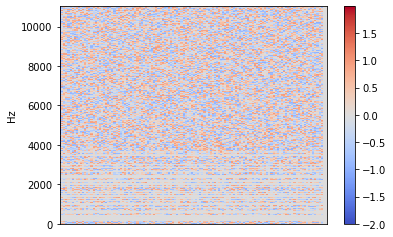

In [91]:
# mel IF 
mel_p[mel_p<-2] = -2
_ = plt.figure()
librosa.display.specshow(mel_p, y_axis='linear')
plt.colorbar()

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

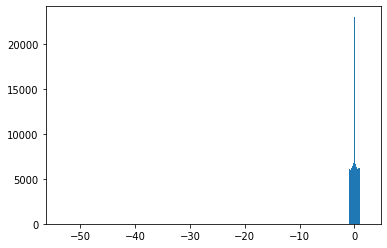

In [84]:
plt.hist(mel_p.flatten(), bins =500)

Preparing data

In [20]:
aud_recon = generate(data)[0] # generate(data, 40)[0] 

samples_recon = reconstruct(aud_recon)
plot_spectrogram_from_samples(samples_recon)
plot_spectrogram_IF(aud_recon)
ipd.Audio(samples_recon, rate=16000)

ParameterError: Audio buffer is not finite everywhere

torch.Size([2, 1024, 128])
tensor(-22.8963, device='cuda:0', grad_fn=<MinBackward1>)
tensor(45.0505, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.0078, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8.7319, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3363, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.3020, device='cuda:0', grad_fn=<MeanBackward0>)


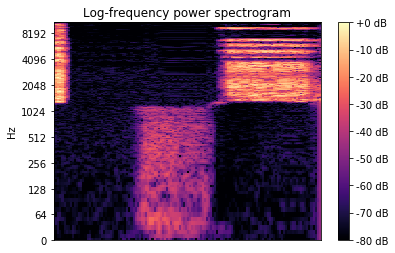

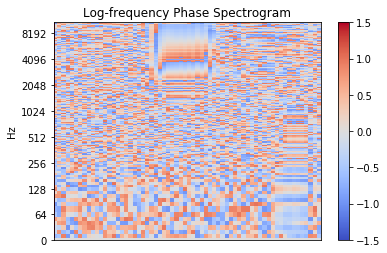

In [40]:
latent = autoencoder.encode(data)
out = autoencoder.decode(latent).squeeze(0)
print(out.size())
print(out[0,:,:].min())
print(out[0,:,:].max())
print(out[0,:,:].mean())

print(out[1,:,:].min())
print(out[1,:,:].max())
print(out[1,:,:].mean())

out = out / torch.max(out)

out = out.cpu().detach().numpy()
samples_recon = reconstruct(out)
plot_spectrogram_from_samples(samples_recon)
plot_spectrogram_IF(out)
ipd.Audio(samples_recon, rate=16000)

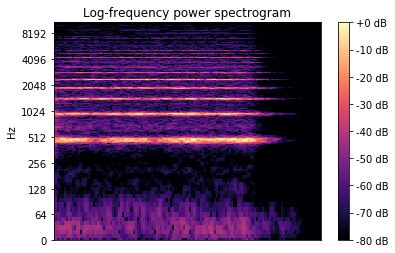

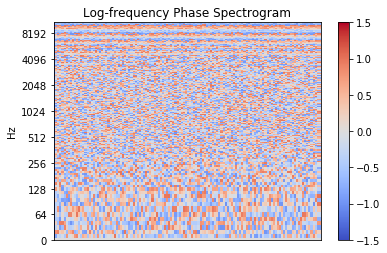

In [21]:
skip_1 = autoencoder.enc_1(data)
pad = torch.zeros_like(skip_1).to(device)

dec_padded_skip = torch.cat([pad,skip_1], dim=1)
fake_out = autoencoder.dec_8(dec_padded_skip)

fake_out = fake_out.squeeze().cpu().detach().numpy()
samples_recon = reconstruct(fake_out)
plot_spectrogram_from_samples(samples_recon)
plot_spectrogram_IF(fake_out)
ipd.Audio(samples_recon, rate=16000)

In [25]:
dataset.include_phase = False
ch_size = 1

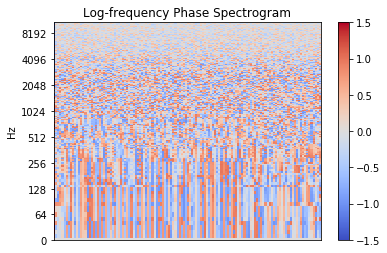

In [24]:
dataset.include_phase = True
ch_size = 2

data_recon = arrange_data(samples_recon)
data_recon = data_recon[0,:,:,:].cpu().detach().numpy()

plot_spectrogram_IF(data_recon[0,:,:], data_recon[1,:,:])

In [28]:
export_audio(samples_recon, os.path.join(output_dir, '512_skiptripV1_{}.wav'.format(sample_name)))

## Pitch Control

First we select and load a sample from the dataset.

Finding a list of pitch encodings gathered from multiple instruments. The idea is to get rid of all information of timbre in the pitch encoding.

In [52]:
available_pitch = list(df['pitch'].unique())
available_pitch.sort()
print(available_pitch)

[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]


In [54]:
pitch_embed_list = []

for pitch in available_pitch:
    sample_row = df[df['pitch'] == pitch].sample(1)
    
    _, sample = scipy.io.wavfile.read(os.path.join(datapath, sample_row.iloc[0]['file'] + '.wav'))
    data = arrange_data(sample)
    
    latent = autoencoder.encode(data) # skip connection
    pitch_embed = torch.chunk(latent, chunks=2, dim=1)[1]
    
    pitch_embed_list.append(pitch_embed.cpu().detach().numpy())
    
print('Pitch Embeddings: {}'.format(len(pitch_embed_list)))
print('Done!')

Pitch Embeddings: 59
Done!


In [61]:
sample_list = ['string_acoustic_022-040-025', 'reed_acoustic_041-065-127']

In [62]:
sample_name = sample_list[1]
_, samples = scipy.io.wavfile.read(os.path.join(datapath, sample_name + '.wav'))
data = arrange_data(samples)
ipd.Audio(samples, rate=16000)

Scale Generation without Skip connections using pitch embeddings with a unique timbre

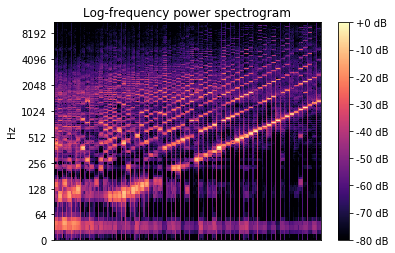

In [63]:
list_audio = []

#latent, skip = autoencoder.encode(data) # Skip connections
latent = autoencoder.encode(data)
timbre = torch.chunk(latent, chunks=2, dim=1)[0]

for pitch_embed in pitch_embed_list[::1]:
    # Format Embedding
    pitch_embed = torch.from_numpy(pitch_embed).float().to(device)
    
    # Concat
    latent = torch.cat([timbre, pitch_embed], dim = 1)
    
    #aud_recon = autoencoder.decode(latent, skip) # Skip connections
    aud_recon = autoencoder.decode(latent)
    aud_recon = aud_recon.squeeze().cpu().detach().numpy()
    aud = reconstruct(aud_recon)
    aud = aud[0:8000]
    list_audio.append(aud)
    
list_audio = np.hstack(list_audio)
plot_spectrogram_from_samples(list_audio)
ipd.Audio(list_audio, rate=16000)

In [64]:
export_audio(list_audio, os.path.join(output_dir, '512_trip_ch_pitch_{}.wav'.format(sample_name)))

## Pitch Interpolation

Scale Generation without Skip connections and pitch interpolation

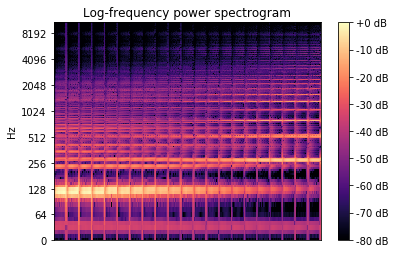

In [58]:
list_audio = []

start_latent = autoencoder.encode(feat_start)
start_timbre, start_pitch = torch.chunk(start_latent, chunks=2, dim=1)
end_latent = autoencoder.encode(feat_end)
end_timbre, end_pitch = torch.chunk(end_latent, chunks=2, dim=1)

iters = 20

for i in range(iters+1):
    alpha = i*(1/iters)
    
    # Interpolation
    pitch_interp = start_pitch*(1-alpha) + end_pitch *alpha
    # Timbre Concat
    latent_interp = torch.cat([start_timbre, pitch_interp], dim = 1)
    
    aud_recon = autoencoder.decode(latent_interp)
    aud_recon = aud_recon.squeeze().cpu().detach().numpy()
    aud = reconstruct(aud_recon)
    aud = aud[0:8000]
    list_audio.append(aud)
    
list_audio = np.hstack(list_audio)
plot_spectrogram_from_samples(list_audio)
ipd.Audio(list_audio, rate=16000)

## Timbre Interpolation

Defining a list of file names with different timbres but same pitch and velocity.

In [74]:
sample_list = ['string_acoustic_042-045-025', 'reed_acoustic_055-045-025', 'brass_acoustic_064-045-025',
               'mallet_acoustic_006-045-025','flute_synthetic_004-045-025']

Defining a list of file names with different timbres and pitch but same velocity.

In [84]:
sample_list = ['string_acoustic_042-050-025', 'reed_acoustic_055-040-025', 'brass_acoustic_064-060-025',
               'mallet_acoustic_006-055-025','flute_synthetic_004-045-025']

In [85]:
_, sample_str = scipy.io.wavfile.read(os.path.join(datapath, sample_list[0] + '.wav'))
ipd.Audio(sample_str, rate=16000)

In [86]:
_, sample_reed = scipy.io.wavfile.read(os.path.join(datapath, sample_list[1] + '.wav'))
ipd.Audio(sample_reed, rate=16000)

In [87]:
_, sample_brass = scipy.io.wavfile.read(os.path.join(datapath, sample_list[2] + '.wav'))
ipd.Audio(sample_brass, rate=16000)

In [88]:
_, sample_mallet = scipy.io.wavfile.read(os.path.join(datapath, sample_list[3] + '.wav'))
ipd.Audio(sample_mallet, rate=16000)

In [89]:
_, sample_flute = scipy.io.wavfile.read(os.path.join(datapath, sample_list[4] + '.wav'))
ipd.Audio(sample_flute, rate=16000)

In [90]:
sample_1 = sample_flute
sample_2 = sample_brass

Sample Interpolation

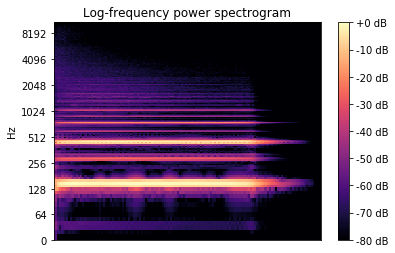

In [72]:
data_1 = arrange_data(sample_1)
data_2 = arrange_data(sample_2)
alpha = 0.5

#latent_1, skip_1 = autoencoder.encode(data_1) # Skip connections
latent_1 = autoencoder.encode(data_1)
timbre_1, pitch_1 = torch.chunk(latent_1, chunks=2, dim=1)
#latent_2, skip_2 = autoencoder.encode(data_2) # Skip connections
latent_2 = autoencoder.encode(data_2)
timbre_2, pitch_2 = torch.chunk(latent_2, chunks=2, dim=1)

# Interpolation
timbre_interp = timbre_1*(1-alpha) + timbre_2 *alpha

# Pitch Concat
latent_interp = torch.cat([timbre_interp, pitch_1], dim = 1)

#aud_recon = autoencoder.decode(latent_interp, skip_1) # Skip connections
aud_recon = autoencoder.decode(latent_interp)
aud_recon = aud_recon.squeeze().cpu().detach().numpy()

# Feature to Wave
audio = reconstruct(aud_recon)

# Qualitative Results
plot_spectrogram_from_samples(audio)
ipd.Audio(audio, rate=16000)

Progressive Latent Interpolation

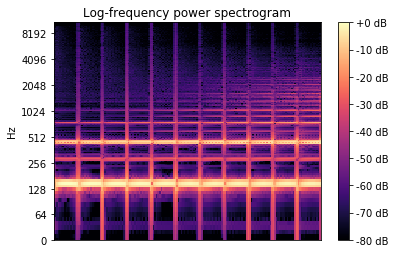

In [74]:
list_audio = []

data_1 = arrange_data(sample_1)
data_2 = arrange_data(sample_2)

#latent_1, skip_1 = autoencoder.encode(data_1) # Skip connections
latent_1 = autoencoder.encode(data_1)
timbre_1, pitch_1 = torch.chunk(latent_1, chunks=2, dim=1)
#latent_2, skip_2 = autoencoder.encode(data_2) # Skip connections
latent_2 = autoencoder.encode(data_2)
timbre_2, pitch_2 = torch.chunk(latent_2, chunks=2, dim=1)

iters = 10

for i in range(iters+1):
    alpha = i*(1/iters)
    
    # Interpolation
    timbre_interp = timbre_1*(1-alpha) + timbre_2 * alpha

    # Pitch Concat
    latent_interp = torch.cat([timbre_interp, pitch_1], dim = 1) # choosing pitch_1 or pitch_2 still has impact
    
    #aud_recon = autoencoder.decode(latent_interp, skip_1) # Skip connections
    aud_recon = autoencoder.decode(latent_interp)
    aud_recon = aud_recon.squeeze().cpu().detach().numpy()
    aud = reconstruct(aud_recon)
    aud = aud[0:8000]
    list_audio.append(aud)
    
list_audio = np.hstack(list_audio)
plot_spectrogram_from_samples(list_audio)
ipd.Audio(list_audio, rate=16000)

Progressive Timbre Latent+SkipCon Interpolation

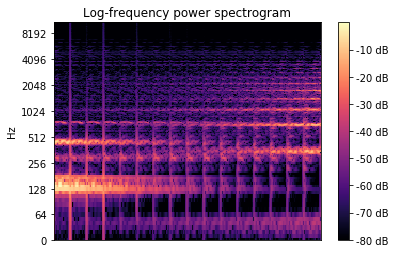

In [91]:
list_audio = []

data_1 = arrange_data(sample_1)
data_2 = arrange_data(sample_2)

latent_1, skip_1 = autoencoder.encode(data_1)
timbre_1, pitch_1 = torch.chunk(latent_1, chunks=2, dim=1)
latent_2, skip_2 = autoencoder.encode(data_2)
timbre_2, pitch_2 = torch.chunk(latent_2, chunks=2, dim=1)

iters = 15
def interpolate_skip(skip_1_list, skip_2_list, alpha, interp_mode='timbre'):
    skip_interp = []
    for skip_1, skip_2 in zip(skip_1_list, skip_2_list):
        if interp_mode == 'timbre':
            timbre_1, pitch_1 = torch.chunk(skip_1, chunks=2, dim=1)
            timbre_2, _ = torch.chunk(skip_2, chunks=2, dim=1)
            timbre_interp = timbre_1*(1-alpha) + timbre_2 * alpha
            skip_interp += [torch.cat([timbre_interp, pitch_1], dim = 1)]
            
        elif interp_mode == 'pitch':
            timbre_1, pitch_1 = torch.chunk(skip_1, chunks=2, dim=1)
            _, pitch_2 = torch.chunk(skip_2, chunks=2, dim=1)
            pitch_interp = pitch_1*(1-alpha) + pitch_2 * alpha
            skip_interp += [torch.cat([timbre_1, pitch_1], dim = 1)]
            
        else: # both
            skip_interp += [skip_1*(1-alpha) + skip_2 * alpha]
    return skip_interp

for i in range(iters+1):
    alpha = i*(1/iters)
    
    # Skip Connection Intepolation
    skip_timbre_interp = interpolate_skip(skip_1, skip_2, alpha)
    
    # Interpolation
    timbre_interp = timbre_1*(1-alpha) + timbre_2 * alpha
    
    # Pitch Concat
    latent_interp = torch.cat([timbre_interp, pitch_1], dim = 1) # choosing pitch_1 or pitch_2 still has impact
    
    aud_recon = autoencoder.decode(latent_interp, skip_timbre_interp)
    aud_recon = aud_recon.squeeze().cpu().detach().numpy()
    aud = reconstruct(aud_recon)
    aud = aud[0:8000]
    list_audio.append(aud)
    
list_audio = np.hstack(list_audio)
plot_spectrogram_from_samples(list_audio)
ipd.Audio(list_audio, rate=16000)

In [73]:
export_audio(list_audio, os.path.join(output_dir, '512_skiptrip_timbinterp.wav'.format(sample_name)))

# References

Visualization
- https://www.datacamp.com/community/tutorials/introduction-t-sne
- https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
- https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
